#  Created by Joshua McCready (jmccread@umich.edu/jmccrea8@ford.com)
## Logistic Regression for Binary Road Wheel Misalgingment Classification
## REQUIRES UPDATE to scikit-learn=0.21.:

>conda config --append channels conda-forge

>conda install scikit-learn==0.21.2 

Above commands allow for some more features in the logistic_regression class

Perform grid search of logistic regression hyper parameters.
Find low weighted elastic net features and recursively remove features until no low weights are left  
Evaluate model selection
Evaluate holdout performance

In [1]:
import numpy as np
import math
import os
from os.path import isfile, join
from os import walk
from pathlib import Path
import pandas as pd
import time
import scipy.io as sio
import matplotlib.pyplot as plt
import itertools  

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFE
from sklearn.metrics import mutual_info_score

import sys
sys.path.append('../') # Feeling cute might delete later
import util.reports as rp
from util.reports import report_feature_ranking
from util.fspp import get_fspp
from util.mutual import MutualInfo
from util.reports import report_feature_ranking

import seaborn as sn
import pickle



## Import data from hard drive

In [2]:
root = r".\..\Data" 
file = os.path.join(root, "df_cat_5Hz.pkl")
df_cat = pd.read_pickle(file)
file = os.path.join(root, "df_num_5Hz.pkl")
df_num = pd.read_pickle(file)
file = os.path.join(root, "df_out_5Hz.pkl")
df_out = pd.read_pickle(file)

## Remove unneeded features on the basis of feature to feature correlation and low mutual information
|Correlation| > 0.98 against another feature: ["Front Right Wheel Speed", "Front Left Wheel Speed", "Rear Right Wheel Speed", "Rear Left Wheel Speed", "Vehicle Yaw Rate"]

low mutual information: ['Total Brake Torque', 'Vehicle Lateral Acceleration', 'Accelerator Pedal Position Percent Rate']

In [3]:
featureNames = df_num.columns # replace with actual list of things
toDrop = ["Front Right Wheel Speed", "Front Left Wheel Speed", "Rear Right Wheel Speed", "Rear Left Wheel Speed", "Vehicle Yaw Rate", 'Total Brake Torque', 'Vehicle Lateral Acceleration', 'Accelerator Pedal Position Percent Rate']
remove = [featureNames.get_loc(label) for label in toDrop]
allFeatures = [df_num.columns.get_loc(label) for label in featureNames]
features = list(set(allFeatures) - set(remove))

## Create X and y, divide train/test, and define model + pipeline

In [4]:
X_full = df_num.iloc[:, features].values
X_labels = df_num.iloc[:, features].columns
# Create binary classifier all postive class are one kind of misalginement or another
y_full = df_out.iloc[:, 3].values >0
X, X_holdout, y, y_holdout = train_test_split(X_full, y_full, test_size = 0.20, random_state = 0)

### What settings are of interest in Logistic regression
1. Penality - l1, l2, or elastic net
2. tol - stoping criteria for gradient descent 
3. class_weight - Using this parameter allos for the values of y to adjust weights to class frequencies. I'm not really sure about this one
4. solver - important because elastic net is supported by saga solver only (I think!)
https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions 
has a really good discussion of the solver algorithms that helped me understand what to do better. Appearently, SAG (Stochastic Average Gradient) is good for larger datasets like this one, but only supports l2 regularization. SAGA is a varaint of SAG but supports l1. 
5. max_iter - Control how much time we give the algorithm to converge


In [5]:
mdl = LogisticRegression(solver='saga', max_iter=500)

sc = StandardScaler()
estimators = [('normalizer', sc), ('classifier', mdl)]
pipe = Pipeline(estimators)

# Create Parameter Space
C_choices = [0.01, 0.25, 0.5, 1, 5]
penalty_choices = ['none', 'l1','l2', 'elasticnet']
l1_ratio_choices = [0.1, 0.5, 0.9]

hyperparams = {
    'classifier__penalty': penalty_choices,
    'classifier__C': C_choices,
    'classifier__l1_ratio': l1_ratio_choices
}

feat_inds = np.arange(0, X.shape[1], 1)

## Setup recursive feature elimination with K folds validation and grid search

In [6]:
# Utility function to report best scores in the cross-validation
def report_cv(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Utility function to report best score among 'elasticnet' to perform RFE - returns relevant features 
def elastic_remove_feats(validator, X, y, pipe, feat_inds, kf):
    elasticRanks = list(np.zeros(len(validator.cv_results_['params']))-1)
    elasticRanksInds = list(np.zeros(len(validator.cv_results_['params'])))
    for i in range(len(validator.cv_results_['params'])):
        params = validator.cv_results_['params'][i]
        if (params['classifier__penalty']) == 'elasticnet':
            elasticRanks[i] = validator.cv_results_['rank_test_score'][i]
            elasticRanksInds[i] = i

    goodRanks = list()
    goodRanksInds = list()
    for i in range(len(elasticRanks)):
        if elasticRanks[i] != -1:
            goodRanks.append(elasticRanks[i])
            goodRanksInds.append(elasticRanksInds[i])

    bestElasticInd = goodRanksInds[np.argmin(goodRanks)]

    alt_pipe = pipe

    i = 0
    alt_params = {} # VERY SEXY
    for param in validator.cv_results_['params'][bestElasticInd]:
        ick = list(validator.cv_results_['params'][bestElasticInd].keys())[i]
        alt_params.update({ick:validator.cv_results_['params'][bestElasticInd][param]})
        i = i+1
        #print(validator.cv_results_['params'][bestElasticInd][param])

    for k, v in alt_params.items():
        alt_pipe.set_params(**{k: v})

    results = cross_validate(alt_pipe, X, y, cv=kf, scoring=['f1'], n_jobs=-1, return_estimator=True, return_train_score=True)
    best_index  = results['train_f1'].argmax()
    coefs = results['estimator'][best_index]['classifier']
    coefs = coefs.coef_
    feat_inds_red = list(feat_inds)
    i = 0
    #print(coefs[0])
    for co in coefs[0]:
        if abs(co) <= 0.04:
            feat_inds_red.pop(i)    
        i = i+1
    return np.asarray(feat_inds_red) 
    

# Printer functions 
def featurePrinter(feat_inds, df_X): 
    print("vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv")
    print("Elastic Net recursive feature elimination, using ", '%d' % len(feat_inds), "features")
    #removed = np.asarray(list(set(feat_inds) - set(red_feat_inds)))
    #print("Features being removed: ")
    #print(df_X.iloc[:, removed].columns)
    print("Features being used: ")
    print(df_X.iloc[:, feat_inds].columns)
    print("----------------------------------------------------------------------------------------------")
    
def resultsPrinter(results, end, start):
    print('Elpased time:', end-start, " seconds")
    print("----------------------------------------------------------------------------------------------")
    print('\nTraining Metrics: ')
    print('Accuracy (Avg): ', '%.2f' % results['train_accuracy'].mean())
    print('F1 Macro (Avg): ', '%.2f' % results['train_f1'].mean())
    print('Recall Macro (Avg): ', '%.2f' % results['train_recall'].mean())
    print('Precision Macro (Avg): ', '%.2f' % results['train_precision'].mean())
    print('\nTime training (Avg): ', results['fit_time'].mean())
    print('\nValidation Metrics: ')
    print('Accuracy (Avg): ', '%.2f' % results['test_accuracy'].mean())
    print('F1 Macro (Avg): ', '%.2f' % results['test_f1'].mean())
    print('Recall Macro (Avg): ', '%.2f' % results['test_recall'].mean())
    print('Precision Macro (Avg): ', '%.2f' % results['test_precision'].mean(), "\n")
    print("----------------------------------------------------------------------------------------------")
    
def removedPrinter(feat_inds, red_feat_inds, df_X): 
    removed = np.asarray(list(set(feat_inds) - set(red_feat_inds)))
    print("Features being removed: ")
    print(df_X.iloc[:, removed].columns)
    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    print("\n")
    

In [7]:
# Utility function to perform recursive feature reduction of k features with cross validation
def RFE(df_X, y, pipe, hyperparams, feat_inds, bestPipeLst, trainPerfLst, validPerfLst, featuresLst, numSplt=3, prevResults=-1, verbose=1):
    
    start = time.perf_counter()
    X = df_X.iloc[:, feat_inds].values # Select the features we want based on previous
    kf = KFold(n_splits = numSplt, random_state = 0,  shuffle=True)

    # Perform Model Selection  #################################################################################
        # Cross validate with model settings ###################################################################
    validator = GridSearchCV(pipe, param_grid=hyperparams, cv=kf, scoring='f1_macro', n_jobs=-1,verbose = 1)
    validator.fit(X, y)
    bestInd = validator.best_index_
    
    bestP = validator.best_estimator_
    featuresLst.append(feat_inds)
    bestPipeLst.append(bestP)
    
    # Use the best result to compute stuff for later ###########################################################
    results = cross_validate(bestP, X, y, cv=kf, scoring=['accuracy', 'f1','precision','recall'], n_jobs=-1, 
                            return_estimator=True, return_train_score=True)
    best_index  = results['train_f1'].argmax()
    trainPerfLst.append([results['train_accuracy'][best_index], results['train_f1'][best_index],
                         results['train_recall'][best_index], results['train_precision'][best_index]]) 
    validPerfLst.append([results['test_accuracy'][best_index], results['test_f1'][best_index],
                         results['test_recall'][best_index], results['test_precision'][best_index]]) 
    
   
    
    # Perform feature selection ###########################################################################
    feat_inds_red = elastic_remove_feats(validator, X, y, pipe, feat_inds, kf)
    
    # Recursive Step  ######################################################################################### 
    if prevResults == -1:
        prevResults = results
    
    end = time.perf_counter()
    report_cv(validator.cv_results_, 5)
    print('Elapsed time: ', end - start, ' seconds\n')
    
    if verbose:
        featurePrinter(feat_inds, df_X)
        resultsPrinter(results, end, start)
        removedPrinter(feat_inds, feat_inds_red, df_X)
        
    if len(feat_inds) <= k:
        print("Stop condition reached, features less than k, returning previous results")
        return feat_inds, results
    elif len(feat_inds) == len(feat_inds_red):
        print("Stop condition reached, did not remove any features")
        return feat_inds, results
    else: 
        return RFE(df_X, y, pipe, hyperparams, feat_inds_red, bestPipeLst, trainPerfLst, validPerfLst, featuresLst, numSplt, results, 1)

## Evaluate the RFE

In [8]:
#resultsLst = list()
bestPipeL = list() 
trainPerfL = list()
validPerfL = list()
featuresL = list()

feat_inds = np.arange(0, X.shape[1], 1)
k = 3
prevResults = -1
df_X = pd.DataFrame(X, columns=np.asarray(X_labels)) 
final_feat_inds, validator = RFE(df_X, y, pipe, hyperparams, feat_inds, bestPipeL, trainPerfL, validPerfL, featuresL, 4, -1, 1)

Fitting 4 folds for each of 60 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.5min finished
C:\Users\JMCCREA8\AppData\Local\Continuum\Anaconda3-5.2.0\lib\site-packages\sklearn\linear_model\logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


Model with rank: 1
Mean validation score: 0.68732 (std: 0.00173)
Parameters: {'classifier__C': 1, 'classifier__l1_ratio': 0.9, 'classifier__penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.68732 (std: 0.00171)
Parameters: {'classifier__C': 5, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.68732 (std: 0.00173)
Parameters: {'classifier__C': 5, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'elasticnet'}

Model with rank: 4
Mean validation score: 0.68731 (std: 0.00175)
Parameters: {'classifier__C': 5, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'none'}

Model with rank: 5
Mean validation score: 0.68731 (std: 0.00168)
Parameters: {'classifier__C': 1, 'classifier__l1_ratio': 0.1, 'classifier__penalty': 'elasticnet'}

Elapsed time:  96.1324859  seconds

vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Elastic Net recursive feature elimination, using  24 features
Feat

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.2min finished
C:\Users\JMCCREA8\AppData\Local\Continuum\Anaconda3-5.2.0\lib\site-packages\sklearn\linear_model\logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


Model with rank: 1
Mean validation score: 0.68198 (std: 0.00188)
Parameters: {'classifier__C': 0.25, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'l1'}

Model with rank: 2
Mean validation score: 0.68198 (std: 0.00188)
Parameters: {'classifier__C': 0.25, 'classifier__l1_ratio': 0.1, 'classifier__penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.68198 (std: 0.00189)
Parameters: {'classifier__C': 1, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'elasticnet'}

Model with rank: 4
Mean validation score: 0.68197 (std: 0.00188)
Parameters: {'classifier__C': 5, 'classifier__l1_ratio': 0.1, 'classifier__penalty': 'none'}

Model with rank: 5
Mean validation score: 0.68196 (std: 0.00185)
Parameters: {'classifier__C': 0.25, 'classifier__l1_ratio': 0.9, 'classifier__penalty': 'l1'}

Elapsed time:  76.32007100000001  seconds

vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Elastic Net recursive feature elimination, using  20 featu

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.0min finished


Model with rank: 1
Mean validation score: 0.68214 (std: 0.00169)
Parameters: {'classifier__C': 0.25, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'elasticnet'}

Model with rank: 2
Mean validation score: 0.68211 (std: 0.00169)
Parameters: {'classifier__C': 0.5, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.68210 (std: 0.00169)
Parameters: {'classifier__C': 0.5, 'classifier__l1_ratio': 0.9, 'classifier__penalty': 'elasticnet'}

Model with rank: 4
Mean validation score: 0.68209 (std: 0.00167)
Parameters: {'classifier__C': 1, 'classifier__l1_ratio': 0.9, 'classifier__penalty': 'elasticnet'}

Model with rank: 5
Mean validation score: 0.68209 (std: 0.00173)
Parameters: {'classifier__C': 0.5, 'classifier__l1_ratio': 0.1, 'classifier__penalty': 'l1'}

Elapsed time:  64.9221082  seconds

vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Elastic Net recursive feature elimination, using  1

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   54.5s finished


Model with rank: 1
Mean validation score: 0.68248 (std: 0.00172)
Parameters: {'classifier__C': 0.5, 'classifier__l1_ratio': 0.1, 'classifier__penalty': 'elasticnet'}

Model with rank: 2
Mean validation score: 0.68246 (std: 0.00170)
Parameters: {'classifier__C': 0.5, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.68246 (std: 0.00167)
Parameters: {'classifier__C': 1, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'elasticnet'}

Model with rank: 4
Mean validation score: 0.68246 (std: 0.00177)
Parameters: {'classifier__C': 0.25, 'classifier__l1_ratio': 0.9, 'classifier__penalty': 'elasticnet'}

Model with rank: 5
Mean validation score: 0.68244 (std: 0.00172)
Parameters: {'classifier__C': 1, 'classifier__l1_ratio': 0.1, 'classifier__penalty': 'l1'}

Elapsed time:  59.017395599999986  seconds

vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Elastic Net recursive feature elimination, us

## Evaluate hold out

In [9]:
y_pred_list = list() 
holdoutPerfL = list()
df_X_holdout = pd.DataFrame(X_holdout, columns=np.asarray(X_labels)) 
len(featuresL)
for i in range(len(featuresL)):
    Bpipe = bestPipeL[i]
    feats = featuresL[i]
    X_holdout_mod = df_X_holdout.iloc[:, feats].values # reduce to right features 
    y_pred = Bpipe.predict(X_holdout_mod)
    y_pred_list.append(y_pred)
    holdoutPerfL.append([accuracy_score(y_pred,y_holdout), f1_score(y_pred,y_holdout),
                         recall_score(y_pred,y_holdout), precision_score(y_pred,y_holdout)]) 

### Plot best pick performance against holdout sets

(16.65, 24.35, 0.7295333904167883, 0.7389602335768578)

<Figure size 432x288 with 0 Axes>

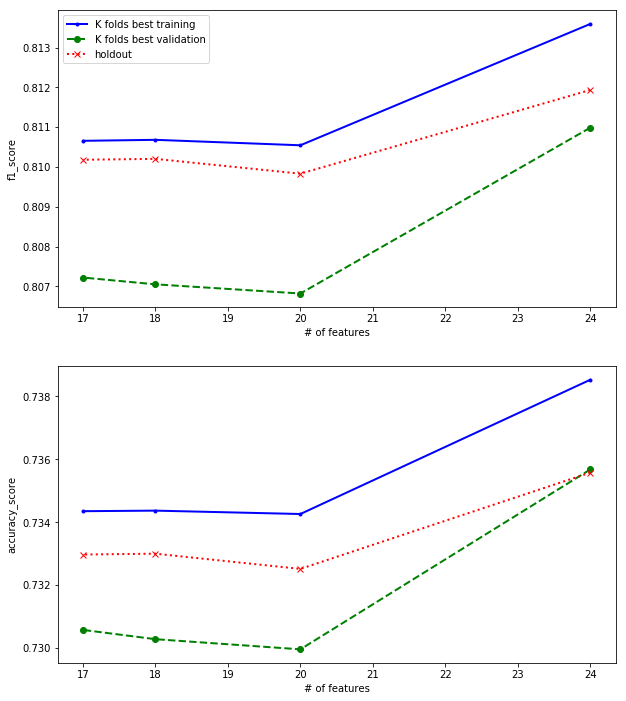

In [10]:
train = np.asarray(trainPerfL)[:,1]
valid = np.asarray(validPerfL)[:,1]
holdout = np.asarray(holdoutPerfL)[:,1]
featLens = list()
[featLens.append(len(feat)) for feat in featuresL]

perfstr = 'f1_score'
fig = plt.figure(1)
plt.subplots(figsize=(10,12))
f1 = plt.subplot(211)
plt.plot( featLens, train, marker='.',  color='blue',  linestyle='-', linewidth=2, label="K folds best training")
plt.plot( featLens, valid, marker='o', color='green', linewidth=2,  linestyle='dashed', label="K folds best validation")
plt.plot( featLens, holdout, marker='x', color='red', linewidth=2, linestyle=':', label="holdout")
plt.ylabel(perfstr)
plt.xlabel('# of features')
plt.legend()
plt.show
plt.axis('auto')
#plt.xticks(np.arange(min(featLens), max(featLens)+1, step=k))
#plt.savefig('f1_naive_bayes.png')

train = np.asarray(trainPerfL)[:,0]
valid = np.asarray(validPerfL)[:,0]
holdout = np.asarray(holdoutPerfL)[:,0]
perfstr = 'accuracy_score'
f1 = plt.subplot(212)
plt.plot( featLens, train, marker='.',  color='blue',  linestyle='-', linewidth=2, label="K folds best training")
plt.plot( featLens, valid, marker='o', color='green', linewidth=2,  linestyle='dashed', label="K folds best validation")
plt.plot( featLens, holdout, marker='x', color='red', linewidth=2, linestyle=':', label="holdout")
plt.ylabel(perfstr)
plt.xlabel('# of features')
#plt.legend()
plt.show
plt.axis('auto')
#plt.xticks(np.arange(min(featLens), max(featLens)+1, step=k))

## Print performance in the holdout dataset against the best model (with 9 features)

In [11]:
best = featLens.index(17) # seems to satisfy the heuristic of low number of features, high f1 and accuracy 
Bpipe = bestPipeL[best]
feats = featuresL[best]
y_pred = y_pred_list[best]
print("vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv")
print('Holdout Test Metrics: ')
print("----------------------------------------------------------------------------------------------")
print('Accuracy: ', '%.2f' % accuracy_score(y_pred,y_holdout))
print('F1 Score: ', '%.2f' % f1_score(y_pred,y_holdout))
print('Recall: ', '%.2f' % recall_score(y_pred,y_holdout))
print('Precision: ', '%.2f' % precision_score(y_pred,y_holdout))
print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")

vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
Holdout Test Metrics: 
----------------------------------------------------------------------------------------------
Accuracy:  0.73
F1 Score:  0.81
Recall:  0.75
Precision:  0.88
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[Text(26.5,0.5,'Output Class'), Text(0.5,8.5,'Target Class')]

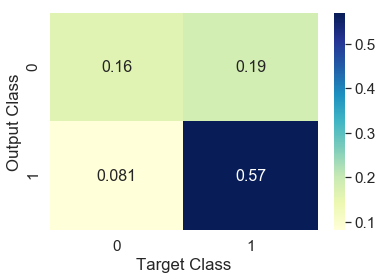

In [12]:
# Making the Confusion Matrix
cm = confusion_matrix(y_holdout, y_pred)
cm_normal = cm/len(y_pred)
sn.set(font_scale=1.4)#for label size
ax = sn.heatmap(cm_normal,  cmap="YlGnBu", annot=True,annot_kws={"size": 16})# font size
ax.set(xlabel='Target Class', ylabel='Output Class')

In [13]:
filename = r".\results\final_logistic_regression" 
pickle.dump(Bpipe, open(filename, 'wb'))
#NB_best = pickle.load(open(filename, 'rb'))
#type(NB_best)